### Import
Import all the necessary packages

In [2]:
import datetime, warnings, scipy
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import geopandas as gdp
import seaborn as sns
from matplotlib.patches import ConnectionPatch
from collections import OrderedDict
from matplotlib.gridspec import GridSpec
# from mpl_toolkits.basemap import Basemap
from sklearn import metrics, linear_model
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from scipy.optimize import curve_fit
plt.rcParams["patch.force_edgecolor"] = True
plt.style.use('fivethirtyeight')
mpl.rc('patch', edgecolor = 'dimgray', linewidth=1)
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last_expr"
pd.options.display.max_columns = 50
%matplotlib inline
warnings.filterwarnings("ignore")

### Data import

Read and import all the competition dataframes

In [4]:
df_airlines = pd.read_csv('Data/airlines.csv')
df_airports = pd.read_csv('Data/airports.csv')
df_flights = pd.read_csv('Data/flights_train.csv', index_col=0)  # first column as index
df_flights_test = pd.read_csv('Data/flights_test.csv', index_col=0)
df_flights

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,DISTANCE,SCHEDULED_ARRIVAL,ARRIVAL_DELAY
id,,,,,,,,,,,,,,,,,
0,2015,1,1,4,AS,98,N407AS,ANC,SEA,5,2354.0,21.0,15.0,205.0,1448,430,-22.0
1,2015,1,1,4,AA,2336,N3KUAA,LAX,PBI,10,2.0,12.0,14.0,280.0,2330,750,-9.0
2,2015,1,1,4,US,840,N171US,SFO,CLT,20,18.0,16.0,34.0,286.0,2296,806,5.0
3,2015,1,1,4,AA,258,N3HYAA,LAX,MIA,20,15.0,15.0,30.0,285.0,2342,805,-9.0
4,2015,1,1,4,AS,135,N527AS,SEA,ANC,25,24.0,11.0,35.0,235.0,1448,320,-21.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2818548,2015,6,30,2,UA,1180,N65832,LAX,ORD,2359,2358.0,11.0,9.0,241.0,1744,600,-8.0
2818549,2015,6,30,2,UA,1192,N69839,LAX,IAH,2359,129.0,11.0,140.0,201.0,1379,520,79.0
2818550,2015,6,30,2,UA,1480,N37298,PDX,IAH,2359,152.0,8.0,200.0,249.0,1825,608,107.0


In [60]:
df_airports.head()

,IATA_CODE,AIRPORT,CITY,STATE,COUNTRY,LATITUDE,LONGITUDE
0,ABE,Lehigh Valley International Airport,Allentown,PA,USA,40.65236,-75.44040
1,ABI,Abilene Regional Airport,Abilene,TX,USA,32.41132,-99.68190
2,ABQ,Albuquerque International Sunport,Albuquerque,NM,USA,35.04022,-106.60919
3,ABR,Aberdeen Regional Airport,Aberdeen,SD,USA,45.44906,-98.42183
4,ABY,Southwest Georgia Regional Airport,Albany,GA,USA,31.53552,-84.19447


In [61]:
def change_time(gg):
    time = "0000"[len(str(gg))-1:-1] + str(gg)
    return time

In [62]:
#test = df_flights.loc[:100, 'SCHEDULED_DEPARTURE':'DEPARTURE_TIME']
#test['DEPARTURE_DELAY'] = test['DEPARTURE_TIME'] - test['SCHEDULED_DEPARTURE']

#test['SCHEDULED_DEPARTURE'] = test['SCHEDULED_DEPARTURE'].apply(lambda row: change_time(row))
#test['DEPARTURE_TIME'] = test['DEPARTURE_TIME'].apply(lambda row: change_time(int(row)))
#test

To get <b>DEPARTURE_DELAY</b>, we need to somehow check if the date between SCHEDULED_DEPARTURE and DEPARTURE_TIME changed. I have no ideal for now how to check if one of the features was before midnight and the second one after, or the other way around. For that we need <b>datime.datime</b> objects of scheduled departure and actual departure.

In [63]:
subset = df_flights.loc[1000:1010, 'SCHEDULED_DEPARTURE':'ARRIVAL_DELAY']
#subset['sch'] = subset['SCHEDULED_DEPARTURE'] + subset['SCHEDULED_TIME']
#subset['sch_diff'] = subset['SCHEDULED_ARRIVAL'] - subset['sch']
subset['ARRIVAL_TIME'] = subset['SCHEDULED_ARRIVAL'] + subset['ARRIVAL_DELAY']
subset['sth'] = subset['SCHEDULED_DEPARTURE'] + subset['SCHEDULED_TIME']
subset

,SCHEDULED_DEPARTURE,DEPARTURE_TIME,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,DISTANCE,SCHEDULED_ARRIVAL,ARRIVAL_DELAY,ARRIVAL_TIME,sth
id,,,,,,,,,,
1000,715,709.0,10.0,719.0,225.0,1371,900,-23.0,877.0,940.0
1001,715,711.0,8.0,719.0,150.0,937,945,-23.0,922.0,865.0
1002,715,712.0,18.0,730.0,205.0,1587,1240,-8.0,1232.0,920.0
1003,715,708.0,9.0,717.0,133.0,622,828,-3.0,825.0,848.0
1004,715,712.0,12.0,724.0,170.0,1023,1005,-1.0,1004.0,885.0
1005,715,719.0,13.0,732.0,199.0,1121,934,-3.0,931.0,914.0
1006,715,747.0,14.0,801.0,375.0,2585,1030,21.0,1051.0,1090.0
1007,715,710.0,19.0,729.0,315.0,2422,1530,-19.0,1511.0,1030.0
1008,715,719.0,12.0,731.0,105.0,551,1000,-5.0,995.0,820.0


### Create date from 'YEAR','MONTH', 'DAY'

In [64]:
df_flights['SCHEDULED_DATE'] = pd.to_datetime(df_flights[['YEAR','MONTH', 'DAY']])

# well, we dont need that
df_flights=df_flights.drop(columns=['YEAR','MONTH', 'DAY','FLIGHT_NUMBER'])

In [65]:
# and move the date to the first column of df_flights
date_col = df_flights['SCHEDULED_DATE']
df_flights.drop(labels=['SCHEDULED_DATE'], axis=1,inplace = True)
df_flights.insert(0, 'SCHEDULED_DATE', date_col)
df_flights

,SCHEDULED_DATE,DAY_OF_WEEK,AIRLINE,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,DISTANCE,SCHEDULED_ARRIVAL,ARRIVAL_DELAY
id,,,,,,,,,,,,,,
0,2015-01-01,4,AS,N407AS,ANC,SEA,5,2354.0,21.0,15.0,205.0,1448,430,-22.0
1,2015-01-01,4,AA,N3KUAA,LAX,PBI,10,2.0,12.0,14.0,280.0,2330,750,-9.0
2,2015-01-01,4,US,N171US,SFO,CLT,20,18.0,16.0,34.0,286.0,2296,806,5.0
3,2015-01-01,4,AA,N3HYAA,LAX,MIA,20,15.0,15.0,30.0,285.0,2342,805,-9.0
4,2015-01-01,4,AS,N527AS,SEA,ANC,25,24.0,11.0,35.0,235.0,1448,320,-21.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2818548,2015-06-30,2,UA,N65832,LAX,ORD,2359,2358.0,11.0,9.0,241.0,1744,600,-8.0
2818549,2015-06-30,2,UA,N69839,LAX,IAH,2359,129.0,11.0,140.0,201.0,1379,520,79.0
2818550,2015-06-30,2,UA,N37298,PDX,IAH,2359,152.0,8.0,200.0,249.0,1825,608,107.0


In [50]:
#df_flights.info()

In [51]:
#df_flights_test.info()

### Transform HH:MM into datetime.time

In [66]:
def transform_HHMM(HHMM):
    '''Function that convert the 'HHMM' string to datetime.time'''
    if pd.isnull(HHMM):
        return np.nan
    else:
        if HHMM == 2400: HHMM = 0
        HHMM = "{0:04d}".format(int(HHMM))
        hour = datetime.time(int(HHMM[0:2]), int(HHMM[2:4]))
        return hour

In [67]:
df_flights['DEPARTURE_TIME'] = df_flights['DEPARTURE_TIME'].apply(transform_HHMM)
df_flights['SCHEDULED_ARRIVAL'] = df_flights['SCHEDULED_ARRIVAL'].apply(transform_HHMM)
df_flights['SCHEDULED_DEPARTURE'] = df_flights['SCHEDULED_DEPARTURE'].apply(transform_HHMM)
df_flights['WHEELS_OFF'] = df_flights['WHEELS_OFF'].apply(transform_HHMM)
df_flights

,SCHEDULED_DATE,DAY_OF_WEEK,AIRLINE,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,DISTANCE,SCHEDULED_ARRIVAL,ARRIVAL_DELAY
id,,,,,,,,,,,,,,
0,2015-01-01,4,AS,N407AS,ANC,SEA,00:05:00,23:54:00,21.0,00:15:00,205.0,1448,04:30:00,-22.0
1,2015-01-01,4,AA,N3KUAA,LAX,PBI,00:10:00,00:02:00,12.0,00:14:00,280.0,2330,07:50:00,-9.0
2,2015-01-01,4,US,N171US,SFO,CLT,00:20:00,00:18:00,16.0,00:34:00,286.0,2296,08:06:00,5.0
3,2015-01-01,4,AA,N3HYAA,LAX,MIA,00:20:00,00:15:00,15.0,00:30:00,285.0,2342,08:05:00,-9.0
4,2015-01-01,4,AS,N527AS,SEA,ANC,00:25:00,00:24:00,11.0,00:35:00,235.0,1448,03:20:00,-21.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2818548,2015-06-30,2,UA,N65832,LAX,ORD,23:59:00,23:58:00,11.0,00:09:00,241.0,1744,06:00:00,-8.0
2818549,2015-06-30,2,UA,N69839,LAX,IAH,23:59:00,01:29:00,11.0,01:40:00,201.0,1379,05:20:00,79.0
2818550,2015-06-30,2,UA,N37298,PDX,IAH,23:59:00,01:52:00,8.0,02:00:00,249.0,1825,06:08:00,107.0


In [68]:
## ADD average SPEED in miles per hour. Can always drop it later
df_flights['SPEED']=round(df_flights['DISTANCE']/(df_flights['SCHEDULED_TIME']/60),3)
df_flights.head()

,SCHEDULED_DATE,DAY_OF_WEEK,AIRLINE,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,DISTANCE,SCHEDULED_ARRIVAL,ARRIVAL_DELAY,SPEED
id,,,,,,,,,,,,,,,
0,2015-01-01,4,AS,N407AS,ANC,SEA,00:05:00,23:54:00,21.0,00:15:00,205.0,1448,04:30:00,-22.0,423.805
1,2015-01-01,4,AA,N3KUAA,LAX,PBI,00:10:00,00:02:00,12.0,00:14:00,280.0,2330,07:50:00,-9.0,499.286
2,2015-01-01,4,US,N171US,SFO,CLT,00:20:00,00:18:00,16.0,00:34:00,286.0,2296,08:06:00,5.0,481.678
3,2015-01-01,4,AA,N3HYAA,LAX,MIA,00:20:00,00:15:00,15.0,00:30:00,285.0,2342,08:05:00,-9.0,493.053
4,2015-01-01,4,AS,N527AS,SEA,ANC,00:25:00,00:24:00,11.0,00:35:00,235.0,1448,03:20:00,-21.0,369.702


### Departure delay

In [12]:
from datetime import datetime

test = df_flights.loc[:10000, 'SCHEDULED_DEPARTURE':'DEPARTURE_TIME']
delays = []

for i in range (test.shape[0]):
    s1 = str(test['DEPARTURE_TIME'][i])
    s2 = str(test['SCHEDULED_DEPARTURE'][i])
    FMT = '%H:%M:%S'
    delay_minutes = (datetime.strptime(s1, FMT) - datetime.strptime(s2, FMT)).total_seconds()/60
    if (delay_minutes < -1100):
        delays.append(1440 + delay_minutes)
    elif (delay_minutes > 1100):
        delays.append(-(1440 - delay_minutes))
    else:
        delays.append(delay_minutes)

        
test["DEPARTURE_DELAY"] = delays
#test['SCHEDULED_DEPARTURE'] = test['SCHEDULED_DEPARTURE'].apply(lambda row: change_time(row))
#test['DEPARTURE_TIME'] = test['DEPARTURE_TIME'].apply(lambda row: change_time(int(row)))

#delays = []

#for i in range (test.shape[0]):
#    if(abs(test['DEPARTURE_TIME'][i] - test['SCHEDULED_DEPARTURE'][i]) < 2000):
#        delays.append(test['DEPARTURE_TIME'][i] - test['SCHEDULED_DEPARTURE'][i])
#    elif (test['DEPARTURE_TIME'][i] > test['SCHEDULED_DEPARTURE'][i]):
#        delays.append((test['DEPARTURE_TIME'][i] - 2360) - test['SCHEDULED_DEPARTURE'][i])
#    else:
#        delays.append((2360 - test['SCHEDULED_DEPARTURE'][i]) + test['DEPARTURE_TIME'][i])

        
#for i in range (len(delays)):
#    if delays[i] > 99:     #212 becomes 132 minutes, 112 becomes 72 minutes
#        hour = int(delays[i] / 100)
#        minutes = delays[i] % 100
#        output = hour*60 + minutes
#        delays[i] = output
#    elif delays[i] > 59 and delays[i] <= 99:  #96 becomes 56, 83 becomes 43
#        output = 60 - (100 - delays[i])
#        delays[i] = output

#now for negative values
#for i in range (len(delays)):
#    if delays[i] < -99:     #-410 becomes -250 minutes
#        hour = int(delays[i] / 100)
#        minutes = -delays[i] % 100
#        output = hour*60 - minutes
#        delays[i] = output
#    elif delays[i] < -59 and delays[i] >= -99:  #96 becomes 56, 83 becomes 43
#        output = delays[i] + 40
#        delays[i] = output

test

,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY
id,,,
0,00:05:00,23:54:00,-11.0
1,00:10:00,00:02:00,-8.0
2,00:20:00,00:18:00,-2.0
3,00:20:00,00:15:00,-5.0
4,00:25:00,00:24:00,-1.0
...,...,...,...
9996,17:35:00,17:30:00,-5.0
9997,17:35:00,17:43:00,8.0
9998,17:35:00,17:26:00,-9.0


### Flights dataframe information
There are no null values


| Column                  | Units     | Description                                       |
|:------------------------|:----------|:--------------------------------------------------|
| **SCHEDULED_DEPARTURE** | [Time]    | Scheduled departure time                          |
| **DEPARTURE_TIME**      | [Time]    | Real departure time                               |
| **TAXI_OUT**            | [minutes] | Taxi minutes around the airport (to runaway)      |
| **WHEELS_OFF**          | [Time]    | Real take-off time -> (DEPARTURE_TIME + TAXI_OUT) |
| **SCHEDULED_TIME**      | [Minutes] | Scheduled flight minutes                          |
| **SCHEDULED_ARRIVAL**   | [Time]    | Scheduled arrival time -> (                       |


# Plots

In [13]:
# Add the number of flights per airport
count_flights = df_flights['ORIGIN_AIRPORT'].value_counts()
count_flights = count_flights.to_frame().rename(columns={"ORIGIN_AIRPORT": "Count Flights"})
count_flights['IATA_CODE'] = count_flights.index
df_airports = pd.merge(df_airports, count_flights)

In [14]:
# define properties of markers and labels
colors = ['blue', 'lightblue', 'yellow', 'orange', 'red']
size_limits = [1, 100, 1000, 10000, 100000]
labels = ['< {}'.format(size_limits[0])]
for i in range(1, len(size_limits)-1):
    labels.append("{} <.< {}".format(size_limits[i], size_limits[i+1]))
labels.append("> {}".format(size_limits[-1]))

df_airports_plot = df_airports.set_index('IATA_CODE')
lab_dict, col_dict = {}, {}
for index, (code, count) in df_airports[['IATA_CODE', 'Count Flights']].iterrows():
    isize = [i for i, val in enumerate(size_limits) if val < count_flights.loc[code]['Count Flights']]
    ind = isize[-1]
    lab_dict[code] = labels[ind]
    col_dict[code] = colors[ind]
df_airports_plot['label'] = pd.Series(lab_dict)
df_airports_plot['color'] = pd.Series(col_dict)
    

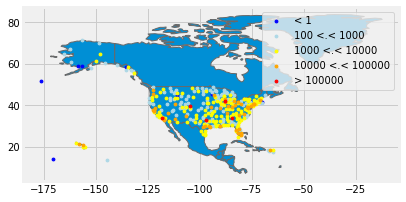

In [17]:
# Add geometry data of airports location:
gdf_airports = gdp.GeoDataFrame(
    df_airports_plot, geometry=gdp.points_from_xy(df_airports.LONGITUDE, df_airports.LATITUDE))
gdf_airports

# We restrict to USA. ->> maybe we could also plot the states
world_df = gdp.read_file(gdp.datasets.get_path("naturalearth_lowres"))
ax = world_df[world_df.continent == 'North America' ].plot()
# ax = world_df[world_df.name == 'United States of America' ].plot()
              
# We can now plot our ``GeoDataFrame``.
for i, col in enumerate(colors):
    gdf_airports[gdf_airports['color'] == col].plot(ax=ax, color=col, markersize=8, label = labels[i])
plt.legend()
plt.show()
plt.rcParams["figure.figsize"] = [10,7]


#### I like this map, good joooob ;)))

## Additional info to airports (wiki tables)

#### Yearly enplanements per airport (data from 2019 though ;/ )

In [18]:
airports_wiki = pd.read_csv('Data/airports_wiki.csv')
airports_wiki = airports_wiki.dropna()
airports_wiki = airports_wiki.drop(columns = ['FAA','ICAO','City','Airport','Role'])
airports_wiki.head()

,IATA,Enplanements
1,BHM,"1,516,075"
2,DHN,"58,860"
3,HSV,"702,574"
4,MOB,"328,245"
5,MGM,"194,990"


In [19]:
airports_merged = pd.merge(df_airports, airports_wiki, how = 'left',left_on = 'IATA_CODE', right_on = 'IATA' )
airports_merged = airports_merged.drop(columns=['IATA'])
airports_merged

,IATA_CODE,AIRPORT,CITY,STATE,COUNTRY,LATITUDE,LONGITUDE,Count Flights,Enplanements
0,ABE,Lehigh Valley International Airport,Allentown,PA,USA,40.65236,-75.44040,1168,"376,769"
1,ABI,Abilene Regional Airport,Abilene,TX,USA,32.41132,-99.68190,1238,"84,809"
2,ABQ,Albuquerque International Sunport,Albuquerque,NM,USA,35.04022,-106.60919,10014,"2,341,719"
3,ABR,Aberdeen Regional Airport,Aberdeen,SD,USA,45.44906,-98.42183,357,"26,529"
4,ABY,Southwest Georgia Regional Airport,Albany,GA,USA,31.53552,-84.19447,476,"41,268"
...,...,...,...,...,...,...,...,...,...
317,WRG,Wrangell Airport,Wrangell,AK,USA,56.48433,-132.36982,351,"14,776"
318,WYS,Westerly State Airport,West Yellowstone,MT,USA,44.68840,-111.11764,51,"8,525"
319,XNA,Northwest Arkansas Regional Airport,Fayetteville/Springdale/Rogers,AR,USA,36.28187,-94.30681,4733,"891,237"
320,YAK,Yakutat Airport,Yakutat,AK,USA,59.50336,-139.66023,352,"12,808"


#### Tried to devide the US into regions, to assign regions to airports (West, South, Midwest, Northeast) 

In [20]:
states = pd.read_csv('Data/states.csv')
states=states.drop(columns=['Cities','Cities.1', 'Population[15]','Total area[16]','Total area[16].1','Land area[16]','Land area[16].1','Water area[16]','Water area[16].1','Numberof Reps.','Ratification oradmission[C]'])
states = states.drop(0)
#states.to_excel('states_regions.xlsx')

In [21]:
states_area = pd.read_excel('Data/states_regions.xlsx', index_col=0)
states_area.head()

,State,Abbreviation,area
1,Alabama,AL,south
2,Alaska,AK,west
3,Arizona,AZ,west
4,Arkansas,AR,south
5,California,CA,west


In [22]:
# Merge regions with aitports.csv
regions_merged = pd.merge(airports_merged, states_area, how = 'left',left_on = 'STATE', right_on = 'Abbreviation' )
regions_merged = regions_merged.drop(columns=['State','Abbreviation'])
regions_merged

,IATA_CODE,AIRPORT,CITY,STATE,COUNTRY,LATITUDE,LONGITUDE,Count Flights,Enplanements,area
0,ABE,Lehigh Valley International Airport,Allentown,PA,USA,40.65236,-75.44040,1168,"376,769",northeast
1,ABI,Abilene Regional Airport,Abilene,TX,USA,32.41132,-99.68190,1238,"84,809",south
2,ABQ,Albuquerque International Sunport,Albuquerque,NM,USA,35.04022,-106.60919,10014,"2,341,719",west
3,ABR,Aberdeen Regional Airport,Aberdeen,SD,USA,45.44906,-98.42183,357,"26,529",midwest
4,ABY,Southwest Georgia Regional Airport,Albany,GA,USA,31.53552,-84.19447,476,"41,268",south
...,...,...,...,...,...,...,...,...,...,...
317,WRG,Wrangell Airport,Wrangell,AK,USA,56.48433,-132.36982,351,"14,776",west
318,WYS,Westerly State Airport,West Yellowstone,MT,USA,44.68840,-111.11764,51,"8,525",west
319,XNA,Northwest Arkansas Regional Airport,Fayetteville/Springdale/Rogers,AR,USA,36.28187,-94.30681,4733,"891,237",south
320,YAK,Yakutat Airport,Yakutat,AK,USA,59.50336,-139.66023,352,"12,808",west


### Preprocessing test file

In [69]:
df_flights_test['SCHEDULED_DATE'] = pd.to_datetime(df_flights_test[['YEAR','MONTH', 'DAY']])
df_flights_test=df_flights_test.drop(columns=['YEAR','MONTH', 'DAY','FLIGHT_NUMBER'])

date_col = df_flights_test['SCHEDULED_DATE']
df_flights_test.drop(labels=['SCHEDULED_DATE'], axis=1,inplace = True)
df_flights_test.insert(0, 'SCHEDULED_DATE', date_col)
#df_flights_test

In [70]:
df_flights_test['DEPARTURE_TIME'] = df_flights_test['DEPARTURE_TIME'].apply(transform_HHMM)
df_flights_test['SCHEDULED_ARRIVAL'] = df_flights_test['SCHEDULED_ARRIVAL'].apply(transform_HHMM)
df_flights_test['SCHEDULED_DEPARTURE'] = df_flights_test['SCHEDULED_DEPARTURE'].apply(transform_HHMM)
df_flights_test['WHEELS_OFF'] = df_flights_test['WHEELS_OFF'].apply(transform_HHMM)
df_flights_test

,SCHEDULED_DATE,DAY_OF_WEEK,AIRLINE,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,DISTANCE,SCHEDULED_ARRIVAL
id,,,,,,,,,,,,,
0,2015-07-01,3,NK,N624NK,LAS,IAH,00:03:00,00:41:00,11.0,00:52:00,177.0,1222,05:00:00
1,2015-07-01,3,AA,N507AY,SFO,CLT,00:05:00,00:00:00,21.0,00:21:00,303.0,2296,08:08:00
2,2015-07-01,3,DL,N3759,LAX,MEM,00:05:00,00:00:00,36.0,00:36:00,223.0,1619,05:48:00
3,2015-07-01,3,NK,N629NK,LAS,MSP,00:05:00,00:53:00,14.0,01:07:00,178.0,1299,05:03:00
4,2015-07-01,3,UA,N39418,ANC,ORD,00:08:00,00:17:00,20.0,00:37:00,364.0,2846,09:12:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
514379,2015-07-31,5,DL,N835DN,PDX,DTW,23:59:00,23:56:00,12.0,00:08:00,248.0,1953,07:07:00
514380,2015-07-31,5,DL,N372DA,PDX,ATL,23:59:00,00:12:00,10.0,00:22:00,274.0,2172,07:33:00
514381,2015-07-31,5,F9,N922FR,DEN,MCO,23:59:00,23:55:00,14.0,00:09:00,213.0,1546,05:32:00


In [71]:
from datetime import datetime

delays = []

for i in range (df_flights_test.shape[0]):
    s1 = str(df_flights_test['DEPARTURE_TIME'][i])
    s2 = str(df_flights_test['SCHEDULED_DEPARTURE'][i])
    FMT = '%H:%M:%S'
    delay_minutes = (datetime.strptime(s1, FMT) - datetime.strptime(s2, FMT)).total_seconds()/60
    if (delay_minutes < -1100):
        delays.append(1440 + delay_minutes)
    elif (delay_minutes > 1100):
        delays.append(-(1440 - delay_minutes))
    else:
        delays.append(delay_minutes)

        
df_flights_test["DEPARTURE_DELAY"] = delays

In [72]:
df_flights_test

,SCHEDULED_DATE,DAY_OF_WEEK,AIRLINE,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,DISTANCE,SCHEDULED_ARRIVAL,DEPARTURE_DELAY
id,,,,,,,,,,,,,,
0,2015-07-01,3,NK,N624NK,LAS,IAH,00:03:00,00:41:00,11.0,00:52:00,177.0,1222,05:00:00,38.0
1,2015-07-01,3,AA,N507AY,SFO,CLT,00:05:00,00:00:00,21.0,00:21:00,303.0,2296,08:08:00,-5.0
2,2015-07-01,3,DL,N3759,LAX,MEM,00:05:00,00:00:00,36.0,00:36:00,223.0,1619,05:48:00,-5.0
3,2015-07-01,3,NK,N629NK,LAS,MSP,00:05:00,00:53:00,14.0,01:07:00,178.0,1299,05:03:00,48.0
4,2015-07-01,3,UA,N39418,ANC,ORD,00:08:00,00:17:00,20.0,00:37:00,364.0,2846,09:12:00,9.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
514379,2015-07-31,5,DL,N835DN,PDX,DTW,23:59:00,23:56:00,12.0,00:08:00,248.0,1953,07:07:00,-3.0
514380,2015-07-31,5,DL,N372DA,PDX,ATL,23:59:00,00:12:00,10.0,00:22:00,274.0,2172,07:33:00,13.0
514381,2015-07-31,5,F9,N922FR,DEN,MCO,23:59:00,23:55:00,14.0,00:09:00,213.0,1546,05:32:00,-4.0


### Adding SPEED to test set

In [73]:
## ADD average SPEED in miles per hour. Can always drop it later
df_flights_test['SPEED']=round(df_flights_test['DISTANCE']/(df_flights_test['SCHEDULED_TIME']/60),3)
df_flights_test.head()

,SCHEDULED_DATE,DAY_OF_WEEK,AIRLINE,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,DISTANCE,SCHEDULED_ARRIVAL,DEPARTURE_DELAY,SPEED
id,,,,,,,,,,,,,,,
0,2015-07-01,3,NK,N624NK,LAS,IAH,00:03:00,00:41:00,11.0,00:52:00,177.0,1222,05:00:00,38.0,414.237
1,2015-07-01,3,AA,N507AY,SFO,CLT,00:05:00,00:00:00,21.0,00:21:00,303.0,2296,08:08:00,-5.0,454.653
2,2015-07-01,3,DL,N3759,LAX,MEM,00:05:00,00:00:00,36.0,00:36:00,223.0,1619,05:48:00,-5.0,435.605
3,2015-07-01,3,NK,N629NK,LAS,MSP,00:05:00,00:53:00,14.0,01:07:00,178.0,1299,05:03:00,48.0,437.865
4,2015-07-01,3,UA,N39418,ANC,ORD,00:08:00,00:17:00,20.0,00:37:00,364.0,2846,09:12:00,9.0,469.121


In [ ]:
test_set['ARRIVAL_DELAY'] = 0

In [74]:
df_flights_test.to_csv('test_set.csv')

In [76]:
test_set = pd.read_csv('Data/test_set.csv', index_col=0)
test_set.head()

,SCHEDULED_DATE,DAY_OF_WEEK,AIRLINE,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,DISTANCE,SCHEDULED_ARRIVAL,DEPARTURE_DELAY,SPEED
id,,,,,,,,,,,,,,,
0,2015-07-01,3,NK,N624NK,LAS,IAH,00:03:00,00:41:00,11.0,00:52:00,177.0,1222,05:00:00,38.0,414.237
1,2015-07-01,3,AA,N507AY,SFO,CLT,00:05:00,00:00:00,21.0,00:21:00,303.0,2296,08:08:00,-5.0,454.653
2,2015-07-01,3,DL,N3759,LAX,MEM,00:05:00,00:00:00,36.0,00:36:00,223.0,1619,05:48:00,-5.0,435.605
3,2015-07-01,3,NK,N629NK,LAS,MSP,00:05:00,00:53:00,14.0,01:07:00,178.0,1299,05:03:00,48.0,437.865
4,2015-07-01,3,UA,N39418,ANC,ORD,00:08:00,00:17:00,20.0,00:37:00,364.0,2846,09:12:00,9.0,469.121


In [5]:
df_airlines

,IATA_CODE,AIRLINE
0,UA,United Air Lines Inc.
1,AA,American Airlines Inc.
2,US,US Airways Inc.
3,F9,Frontier Airlines Inc.
4,B6,JetBlue Airways
5,OO,Skywest Airlines Inc.
6,AS,Alaska Airlines Inc.
7,NK,Spirit Air Lines
8,WN,Southwest Airlines Co.
9,DL,Delta Air Lines Inc.
